In [1]:
import scanpy as sc
from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
import scvelo as scv
import numpy as np
import pandas as pd
from pandas import DataFrame
import cloudpickle

import jax.numpy as jnp

In [2]:
settings = ['', 'gastrulation', '10k', 'integrated', 'weighted']

In [3]:
def preparation(adata, model, x_key):
    adata.obsm['velocity'] = np.array(fm.transport(jnp.array(adata.obsm[x_key]), 
                                   condition=np.expand_dims(adata.obs.day.values, axis=1), 
                                   forward=True)
                      )-adata.obsm[x_key]
    adata.layers['spliced'] = np.ones((adata.n_obs, adata.n_vars))
    adata.layers['unspliced'] = np.ones((adata.n_obs, adata.n_vars))

    if settings[3]=='integrated':
        sc.pp.neighbors(adata, use_rep=x_key)
    else:
        sc.pp.neighbors(adata, use_rep=x_key)
    sc.tl.umap(adata)
    scv.pp.moments(adata)
    return None



In [4]:
if settings[1]=='atlas':
    pass
elif settings[1]=='gastrulation':
    terminal_states = ['PGC', 'Mesenchyme', 'Surface ectoderm', 'Gut', 'Notochord', 'Somitic mesoderm', 'Endothelium', 'Forebrain/Midbrain/Hindbrain', 'Spinal cord', 'Cardiomyocytes', 'NMP', 'Erythroid3', 'Neural crest']
else:
    terminal_states = ['Amnion', 'Blood', 'Neural Crest/Mid-HindBrain', 'Mid-Hind Gut', 'Foregut/Placodes', 'Mixed mesoderm', 'Extra-Embryonic endoderm', 'Extra-Embryonic ectoderm', 'Endothelial', 'Cardiac', 'Endothelial/Mixed', 'Placodes/Extra-Embryonic mesoderm']

In [5]:
if settings[1]=='atlas':
    adata = sc.read_h5ad(f'/home/icb/jonas.flor/gastrulation_atlas/scvi/training/1M/{settings[2]}_genes/2/2048/{settings[3]}_adata.h5ad')
    cluster_key = 'cellcluster_moscot'
    n_states = int(len(adata.obs.cellcluster_moscot.unique())*1.5)
else:
    adata = sc.read_h5ad(f'/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/scarches/1M/{settings[2]}_genes/2/2048/{settings[1]}/{settings[1]}_adata.h5ad')
    cluster_key = 'celltype'
    n_states = int(len(adata.obs.celltype.unique())*1.5)

if settings[3] == 'unintegrated' and settings[1]=='atlas':
    x_key = 'X_pca'
else:
    x_key = 'X_emb'

if settings[4]=='weighted':
    end = '_w'
else:
    end = ''

In [6]:
with open(f'/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/divergences/flow/1M/{settings[2]}_genes/2/2048/{settings[3]}_cond_model{end}.pt', mode='rb') as file:
       fm = cloudpickle.load(file)

preparation(adata, fm, x_key)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:07:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
vk = VelocityKernel(adata, attr='obsm', xkey=x_key, vkey="velocity").compute_transition_matrix()
g = GPCCA(vk)

g.compute_macrostates(cluster_key=cluster_key, n_states=n_states)
g.predict_terminal_states()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89267/89267 [00:16<00:00, 5551.39cell/s]


In [ ]:
terminal_states_contained = 0
for state in terminal_states:
    if any([terminal_state.startswith(state) for terminal_state in g.terminal_states.cat.categories.astype('string')]):
        terminal_states_contained = terminal_states_contained+1
terminal_states_contained 

In [ ]:
sc.pl.umap(adata, color='celltype')

In [ ]:
#terminal_states_found = terminal_states_contained/len(g.terminal_states.cat.categories)
#pd.DataFrame({'terminal_states_found': [terminal_states_found]}).to_csv(f'/home/icb/jonas.flor/gastrulation_atlas/scvi/downstream_analysis/{sys.argv[1]}/{sys.argv[2]}/{sys.argv[3]}/{sys.argv[4]}/terminal_cells.csv')

g.compute_fate_probabilities()#tol=1e-20)#preconditioner='ilu')#
g.plot_fate_probabilities(same_plot=False)

In [27]:
db = pd.read_csv('/home/icb/jonas.flor/gastrulation_atlas/data/mouse.v12.geneID.txt', sep='\t')[['gene_ID', 'gene_short_name']]
for t in g.terminal_states.cat.categories.astype('string'):
    try:
    	driver_genes = g.compute_lineage_drivers(lineages = t, cluster_key=cluster_key)
    	annotations = [db[db.gene_ID==x]['gene_short_name'].values[0] for x in driver_genes.index]
    	driver_genes['gene_annotation'] = annotations

SyntaxError: incomplete input (2274944278.py, line 6)

In [2]:
#Old

In [3]:
adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/scarches/1M/10k_genes/2/2048/invito/invito_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 26948 × 10000
    obs: 'day', 'celltype'
    uns: 'log1p', 'pca'
    obsm: 'X_emb', 'X_pca'
    varm: 'PCs'

In [6]:
adata_tmp.obsm['velocity'] = np.array(fm.transport(jnp.array(adata_tmp.obsm['X_emb']), 
                               condition=np.expand_dims(adata_tmp.obs.day.values, axis=1), 
                               forward=True)
                  )-adata_tmp.obsm['X_emb']

In [28]:
adata.obs.celltype.unique()[10:]

['Endothelial', 'Extra-Embryonic mesoderm', 'Cardiac', 'Endothelial/Mixed', 'Placodes/Extra-Embryonic mesoderm']
Categories (15, object): ['Amnion', 'Blood', 'Cardiac', 'Endothelial', ..., 'Mixed mesoderm', 'Neural Crest/Mid-HindBrain', 'Pharyngeal Mesoderm/Neural Crest', 'Placodes/Extra-Embryonic mesoderm']

In [21]:
adata

AnnData object with n_obs × n_vars = 26948 × 10000
    obs: 'day', 'celltype', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'schur_matrix_fwd', 'eigendecomposition_fwd'
    obsm: 'X_emb', 'X_pca', 'velocity', 'X_umap', 'schur_vectors_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [7]:
adata_tmp.layers['spliced'] = np.ones((adata_tmp.n_obs, adata_tmp.n_vars))
adata_tmp.layers['unspliced'] = np.ones((adata_tmp.n_obs, adata_tmp.n_vars))
adata_tmp

AnnData object with n_obs × n_vars = 5000 × 10000
    obs: 'day', 'celltype'
    uns: 'log1p', 'pca'
    obsm: 'X_emb', 'X_pca', 'velocity'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

In [8]:
sc.pp.neighbors(adata_tmp, use_rep='X_emb')
sc.tl.umap(adata_tmp)
scv.pp.moments(adata_tmp)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:17) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
vk = VelocityKernel(adata_tmp, attr='obsm', xkey="X_emb", vkey="velocity").compute_transition_matrix()
g = GPCCA(vk)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4286.86cell/s]


In [11]:
g.compute_macrostates(cluster_key='celltype', n_states=int(len(adata_tmp.obs.celltype.unique())*1.5))

GPCCA[kernel=VelocityKernel[n=5000], initial_states=None, terminal_states=None]

In [12]:
g.predict_terminal_states()

ValueError: No macrostates have been selected.

In [ ]:
for d in g.terminal_states.cat.categories:
    print(d)

In [25]:
g.compute_fate_probabilities()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.99/s]


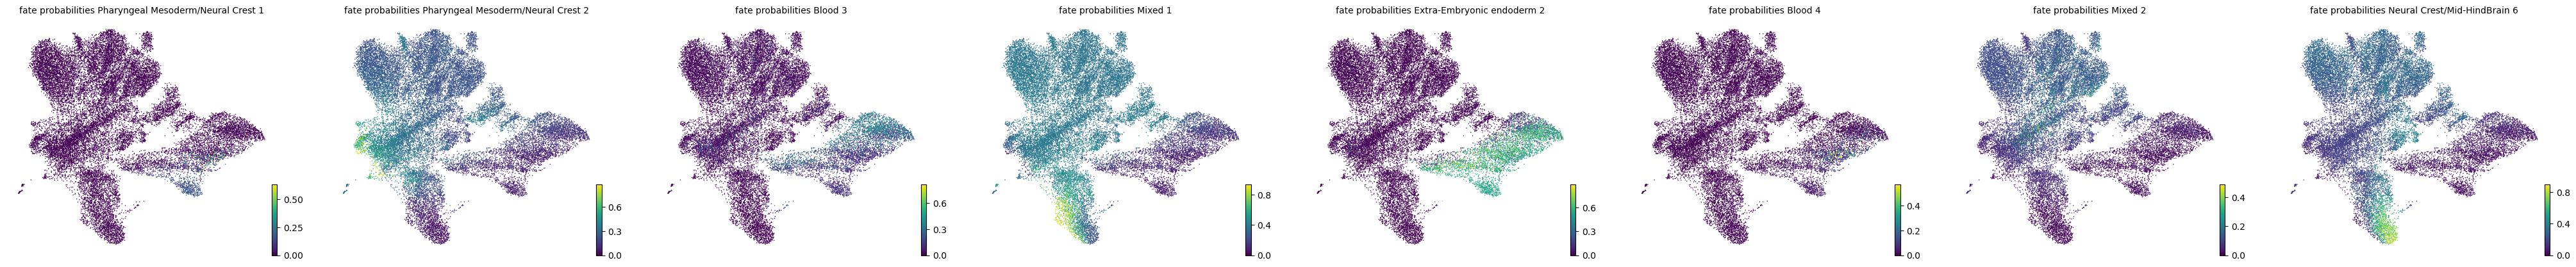

In [26]:
g.plot_fate_probabilities(same_plot=False)

In [61]:
db = pd.read_csv('/home/icb/jonas.flor/gastrulation_atlas/data/mouse.v12.geneID.txt', sep='\t')[['gene_ID', 'gene_short_name']]
annotations = [db[db.genex]['gene_short_name'] for x in driver_genes.index]

['Tsfm',
 'Nubp2',
 'Rexo2',
 'Mrpl18',
 'Pycr2',
 'Samm50',
 'Ung',
 'Rplp2',
 'Gfi1b',
 'Wdr55',
 'Klf1',
 'Glrx5',
 'Prdx2',
 'Prdx3',
 'Hdgf',
 'Alad',
 'Hmbs',
 'Aurkaip1',
 'Gclm',
 'Anp32b',
 'Meiob',
 'Pa2g4',
 'Gmpr',
 'Prdx6',
 'Exoc8',
 'Pno1',
 'Car2',
 'Stoml2',
 'Psmb10',
 'Tmem14c',
 'Cyc1',
 'Gpx1',
 '1700037H04Rik',
 'Ccdc43',
 'Rpl30',
 'Fth1',
 'Cpne7',
 'Hbb-bh1',
 'Rad23a',
 '2210016F16Rik',
 'Rpp25l',
 'Sod1',
 'Epor',
 'Acmsd',
 'Lyl1',
 'Pop7',
 'Plin2',
 'Ddx39',
 'Cpox',
 'Pklr',
 'Il4',
 'Bop1',
 'Nars',
 'Hemgn',
 'Asns',
 'Ifrd2',
 'Mrpl46',
 'Prokr1',
 'Trim10',
 'Gypa',
 'Dyrk3',
 'Copz1',
 'Padi2',
 'Blvra',
 '2310011J03Rik',
 'Rpl36al',
 'Pfdn6',
 'Taldo1',
 'Hebp1',
 'Nhp2',
 'Ecsit',
 'Srm',
 'Add2',
 'Ttll12',
 'Chchd10',
 'Scube2',
 'Atp5g3',
 'Rnaseh2a',
 'Nhp2l1',
 'Psmc2',
 'Ggct',
 'Ube2l6',
 'Ssx2ip',
 'Abcb6',
 'Cited4',
 'Ddx21',
 '1110006O24Rik',
 'Imp3',
 'Uqcrc1',
 'C1qbp',
 'Fam109b',
 'Psme3',
 'Hagh',
 'Angptl4',
 'Rbm38',
 'Gadd45gip1'

# old

In [50]:
def macrostate_computation(g: GPCCA, terminal_states: List[str], steplength: int = 5) -> Tuple[List[str], int, int]:
    """
    Method for computing the minimal number of macrostates such that all terminal states are contained in the
    macrostates. Furthermore, a list with the real terminal state names according to the GPCCA-model is created.

    :param g: GPCCA model
    :param terminal_states: List of terminal states that g should contain
    :param steplength: length of the step when searching for the minimal number of macrostates
    :return: Terminal states of the model, the total number of terminal states and the required number of macrostates
    """
    n_term_states, i_macro_states = terminal_state_search(g, terminal_states=terminal_states, steplength=steplength)

    terminal_states_model = []
    for macro_state in g.terminal_states.cat.categories.astype('string'):
        for state in terminal_states:
            if macro_state.startswith(state):
                terminal_states_model.append(macro_state)
                break

    return terminal_states_model, n_term_states, i_macro_states


def terminal_state_search(g: GPCCA, terminal_states: List[str], steplength: int) -> Tuple[int, int]:
    """
    Computation of the minimal number of macrostates such that given terminal states are contained in the GPCCA model.
    :param g: GPCCA model
    :param terminal_states: List of required terminal states in the GPCCA model
    :param steplength: step size in which the number of macrostates are elevated
    :return: total number of terminal states n and the required number of macrostates i
    """
    i = len(terminal_states)
    contains = False

    # incrementation of the number of macrostates by steplength until all terminal states are detected
    while not contains:
        try:
            contains, _, _ = step(g, terminal_states, i)
            if contains:
                break
            i += steplength
        except ValueError:
            contains = False
            print('Computation of ' + str(i) + ' macrostates not possible. Trying ' + str(i + 1) + ' states')
            i += 1

    up = i
    down = i - steplength
    step_new = steplength
    n_term_states_up = None
    i_macro_states_up = None

    # Search for the minimal number of required macrostates by doing binary search the interval [down, up]
    while up - down > 1:
        step_new = max(step_new // 2, 1)
        while down + step_new >= up:
            step_new = max(step_new // 2, 1)
        try:
            contains, n_term_states, i_macro_states = step(g, terminal_states, down + step_new)
            if contains:
                up = down + step_new
                n_term_states_up = n_term_states
                i_macro_states_up = i_macro_states
            else:
                down = down + step_new
        except ValueError:
            down += 1

    g.compute_macrostates(n_states=i_macro_states_up, cluster_key="celltype")
    g.predict(n_states=n_term_states_up, method='top_n')

    return n_term_states_up, i_macro_states_up


def step(g: GPCCA, terminal_states: List[str], n_states: int) -> Tuple[bool, int, int]:
    """
    Check if given terminal states are contained within n_states macrostates
    :param g: GPCCA model
    :param terminal_states: terminal states. The beginnings of the terminal states must be unique and no name can be
            contained in another
    :param n_states: number of macrostates
    :return: whether the terminal states are contained in the macrostates, the number of used macrostates and the number
            of estimated terminal states with all required terminal states
    """
    g.compute_macrostates(n_states=n_states, cluster_key="celltype")
    n_term_states, i_macro_states, contains = None, None, None
    for n in range(len(terminal_states), n_states + 1):
        g.predict(n_states=n, method='top_n')
        contains = True
        for state in terminal_states:
            # if a state isn't contained in the predicted terminal states, contains will become false
            contains = any([terminal_state.startswith(state) for terminal_state in
                            g.terminal_states.cat.categories.astype('string')])
            # then the number of predicted terminal states must be incremented
            if not contains:
                break
        if contains:  # contains: True, if all terminal states contained in g.terminal_states
            n_term_states = n
            i_macro_states = n_states
            break

    return contains, n_term_states, i_macro_states


def computation_transition_probabilities(g: GPCCA, terminal_states_model: List[str], states: List[str]) -> DataFrame:
    """
    Computation of matrix with values as in cellrank.pl.aggregate_absorption_probabilities
    :param g: GPCCA model
    :param terminal_states_model: terminal states in the model
    :param states: all possible states in the dataset
    :return: Dataframe with aggregated absorption probabilities after terminal states in the model and states in the
            dataset
    """
    import pandas as pd
    import numpy as np

    g.set_terminal_states(terminal_states_model)
    g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')

    terminal_cluster = terminal_states_model

    aggregated_absorption_prob = np.empty((len(terminal_cluster), len(states)))
    data = g.absorption_probabilities.X
    tmp = g.adata.obs['celltype']

    for i in range(len(states)):
        aggregated_absorption_prob[:, i] = np.dot(np.array((tmp.array == states[i]).astype(int)), data)
    for i in range(len(states)):
        aggregated_absorption_prob[:, i] = aggregated_absorption_prob[:, i] / np.sum(aggregated_absorption_prob[:, i])
    df = pd.DataFrame(aggregated_absorption_prob)
    df.index = terminal_cluster
    df.columns = states

    return df


def mean_correct_transition_prob(transition_probabilities: DataFrame, transitions: List[Tuple[str, str]]) -> float:
    """
    :param transition_probabilities: probability of cell fate after model
    :param transitions: correct transitions
    :return: mean of correctly identified transitions
    """
    correct_transitions = []
    for trans in transitions:
        for terminal in transition_probabilities.index:
            if terminal.startswith(trans[1]):
                correct_transitions.append((trans[0], terminal))

    sum_prob = 0
    for i in correct_transitions:
        sum_prob = sum_prob + transition_probabilities.loc[i]
    mean_prob = sum_prob / len(transition_probabilities.columns)

    return mean_prob
